In [1]:
import os
os.chdir('..')

In [2]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Dataset generator
input_dim   = 30*4
pred_dim    = 30*2
shift       = pred_dim
data        = DS(input_dim, pred_dim, shift, skip=1, hop=0.1, normalizer=1)

In [4]:
data.Train.element_spec

(TensorSpec(shape=(None, 120, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 60, 1), dtype=tf.float64, name=None))

In [5]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [6]:
INPUT_DIM = data.xshape
OUTPUT_DIM = data.yshape

In [7]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: 120
Output dim: 60


In [13]:
oneshot_rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=[INPUT_DIM, 1]),
    tf.keras.layers.Dense(OUTPUT_DIM)
])

In [14]:
oneshot_rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 60)                7740      
                                                                 
Total params: 74,300
Trainable params: 74,300
Non-trainable params: 0
_________________________________________________________________


In [15]:
MAX_EPOCHS = 20

def lr_optimizer(model, window, patience=2):

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-7 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS,
                      validation_data=window.Val,
                      callbacks=[lr_scheduler])
  return history

In [16]:
history = lr_optimizer(oneshot_rnn_model, data)

Epoch 1/20
2738/2738 [==============================] - 105s 38ms/step - loss: 15.2822 - mean_absolute_percentage_error: 148.3496 - mean_absolute_error: 1.9759 - val_loss: 8.8733 - val_mean_absolute_percentage_error: 126.5278 - val_mean_absolute_error: 1.5410 - lr: 1.0000e-07
Epoch 2/20
2170/2738 [======================>.......] - ETA: 20s - loss: 19.1159 - mean_absolute_percentage_error: 156.3536 - mean_absolute_error: 2.3853

(1e-05, 0.001, 0.0, 20.0)

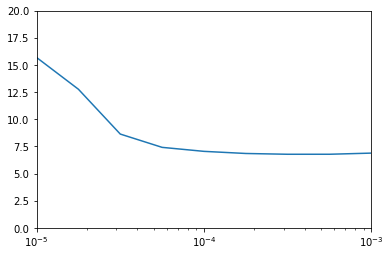

In [ ]:
lrs = 1e-5 * (10 ** (np.arange(MAX_EPOCHS) / 4))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-5, 1e-3, 0, 20])

In [ ]:
oneshot_rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, input_shape=[INPUT_DIM, 1]),
    tf.keras.layers.Dense(OUTPUT_DIM)
])

In [ ]:
MAX_EPOCHS_TRAINING = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(learning_rate=1e-6),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS_TRAINING,
                      validation_data=window.Val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history_training = compile_and_fit(oneshot_rnn_model, data)

Epoch 1/50
2738/2738 [==============================] - 11s 4ms/step - loss: 15.5703 - mean_absolute_percentage_error: 382.5428 - mean_absolute_error: 1.9267 - val_loss: 8.4941 - val_mean_absolute_percentage_error: 183.6258 - val_mean_absolute_error: 1.4975
Epoch 2/50
2738/2738 [==============================] - 11s 4ms/step - loss: 13.8828 - mean_absolute_percentage_error: 504.6201 - mean_absolute_error: 1.8486 - val_loss: 7.0495 - val_mean_absolute_percentage_error: 261.8087 - val_mean_absolute_error: 1.3449
Epoch 3/50
2738/2738 [==============================] - 11s 4ms/step - loss: 11.6106 - mean_absolute_percentage_error: 856.0525 - mean_absolute_error: 1.6606 - val_loss: 5.5768 - val_mean_absolute_percentage_error: 348.3853 - val_mean_absolute_error: 1.1778
Epoch 4/50
2738/2738 [==============================] - 12s 4ms/step - loss: 9.8274 - mean_absolute_percentage_error: 876.2321 - mean_absolute_error: 1.5115 - val_loss: 4.6665 - val_mean_absolute_percentage_error: 377.0802 - v

In [ ]:
val_performance = oneshot_rnn_model.evaluate(data.Val)
test_performance = oneshot_rnn_model.evaluate(data.Test)

In [ ]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))